# Introduction: Galaxy Optical Morphology

In 1926, Edwin Hubble devised a scheme, known as the **Hubble Sequence**, to classify galaxies based on their visual morphology. The Hubble Sequence divides galaxies into **ellipticals, spirals, irregulars and lenticulars**, which represent the transition between ellipticals and spirals.

The Hubble Sequence matters because galaxy properties meaningfully vary between Hubble types. Ellipticals are typically larger, brighter, older than spirals and irregulars. Spiral galaxies have distinct disk and bulge structures, and the study of stellar kinematics in spirals helped scientists uncover the existence of mysterious dark matter, one of the biggest enigmas in modern astronomy. Irregular galaxies, by contrast, can sometimes have surprisingly high star formation rates and violent evolutionary histories. 

Understanding how the relative abundance of galaxies of different morphological types changed over cosmic time is key to reconstructing the **formation and evolution of galaxies**, and by extension, the history of the universe itself.

# Aim: Galaxy Classification

In this project, I aim to create a neural network algorithm to **accurately classify galaxies**. I will use the **Galaxy10 dataset**, which consists of ~18,000 galaxy images manually classified into ten galaxy classes, inspired by the Hubble Sequence.

Through this exercise, I would like to familiarize myself with the **deep learning workflow**, including data preprocessing and augmentation, model protyping and iteration, performance benchmarking, and model selection and evaluation. 

# Galaxy10 Dataset 

The Galaxy10 dataset contains 17,736 galaxy images, with a resolution of 256x256 pixels and three color channels. Each galaxy is classified into one of ten classes: *Disturbed, Merging, Round Smooth, In-between Round Smooth, Cigar Shaped Smooth, Barred Spiral, Unbarred Tight Spiral, Unbarred Loose Spiral, Edge-on without Bulge and Edge-on with Bulge*. 

The class distribution is **moderately imbalanced**: Most classes have between 1800 to 2600 samples, but the *Cigar Shaped Smooth* and *Disturbed* classes are significantly underrepresented with only 334 and 1081 samples, respectively. (Source: https://astronn.readthedocs.io/en/latest/galaxy10.html).

In [6]:
# Load necessary packages
from astroNN.datasets.galaxy10 import galaxy10cls_lookup
from astroNN.datasets import load_galaxy10
from tensorflow.keras import utils
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision.models import resnet50, ResNet50_Weights, resnet152, ResNet152_Weights
from PIL import Image
import math
from torchvision.transforms.v2 import RandomAffine
from torch import nn 
from torch import optim
from torchvision.transforms import Normalize
from torchvision import models
from sklearn.metrics import confusion_matrix, make_scorer, precision_score, f1_score, average_precision_score
from sklearn.utils.class_weight import compute_class_weight
import tqdm

AttributeError: partially initialized module 'torch' has no attribute 'version' (most likely due to a circular import)

In [ ]:
# Load images and labels (will download automatically the first time)
# First time downloading location will be ~/.astroNN/datasets/
images, labels = load_galaxy10()

# Convert the labels to categorical 10 classes
labels_categorical = utils.to_categorical(labels, 10)

# Convert to desirable type
labels_categorical = labels_categorical.astype(np.float32)
images = images.astype(np.float32)

In [ ]:
# Print some basic information
n, width, height, n_colors = images.shape
print(f'Number of data points: {n}')
print(f'Width of images: {width}')
print(f'Height of images: {height}')
print(f'Number of colors: {n_colors}')

In [ ]:
# Check for class imbalance
l, c = np.unique(labels, return_counts=True)
uniques = {galaxy10cls_lookup(ui): li for ui, li in zip(l, c)}
uniques

In [ ]:
# Plot some images with labels
f, axes = plt.subplots(3, 3, figsize=(9, 9))

rand = random.sample(range(n), 9)
for r, ax in zip(rand, axes.ravel()):

    image, label = images[r], labels[r]
    ax.imshow(image / 255.0)
    label_name = galaxy10cls_lookup(label)
    ax.set_title(label_name)

    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

plt.tight_layout()

# Data Preprocessing and Augmentation

As mentioned above, the Galaxy10 dataset only contains 17,736 samples, and the class distribution is moderately imbalanced. Training a deep learning model on such a dataset presents several challenges: the model may overfit the training data, and lack in its generalization ability; it may perform especially poorly on minority classes; and it may be unable to learn complex features in the data. 

To address these issues, I will apply **data augmentation** to modify the existing training data using techniques such as rotation, scaling, translation, and color jittering, with the goal of increasing the variability of the training dataset to improve model generalizability. 

In [ ]:
# Create a custom dataset class and initialize dataset object
class Galaxy10Dataset(Dataset):
    def __init__(self, images, labels, transform=None, train=True, split=0.3):
        super().__init__()
        self.images = images
        self.labels = labels

        # Fallback to default if no transforms are specified
        self.transform = transform if transform else transforms.Compose([transforms.ToTensor()])

        # Train test splitting
        l = len(self.labels)
        val_len = math.floor(l * split)
        train_len = l - val_len
        if train:
            self.images = self.images[0:train_len]
            self.labels = self.labels[0:train_len]
        else:
            self.images = self.images[train_len:l]
            self.labels = self.labels[train_len:l]

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx].astype("uint8"))
        label = self.labels[idx]
        return self.transform(image), label

    def __len__(self):
        return len(self.labels)

In [ ]:
# Shuffle dataset before splitting into training and validation sets
tmp = list(zip(images, labels))
random.shuffle(tmp)
images, labels = zip(*tmp)

In [ ]:
# Define augmentation routine for training data 
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=(-180, 180), translate=(0.05, 0.15), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

# Generate training and validation dataset objects
gal_train_ds = Galaxy10Dataset(images=images, labels=labels, transform=transform_train)
gal_valid_ds = Galaxy10Dataset(images=images, labels=labels, train=False, transform=None)

In [ ]:
print(len(gal_train_ds))
print(len(gal_valid_ds))

In [12]:
# Initialize dataloader
from torch.utils.data import DataLoader


batch_size = 32
gal_train_dl = DataLoader(gal_train_ds, batch_size=batch_size)
gal_valid_dl = DataLoader(gal_valid_ds, batch_size=batch_size)

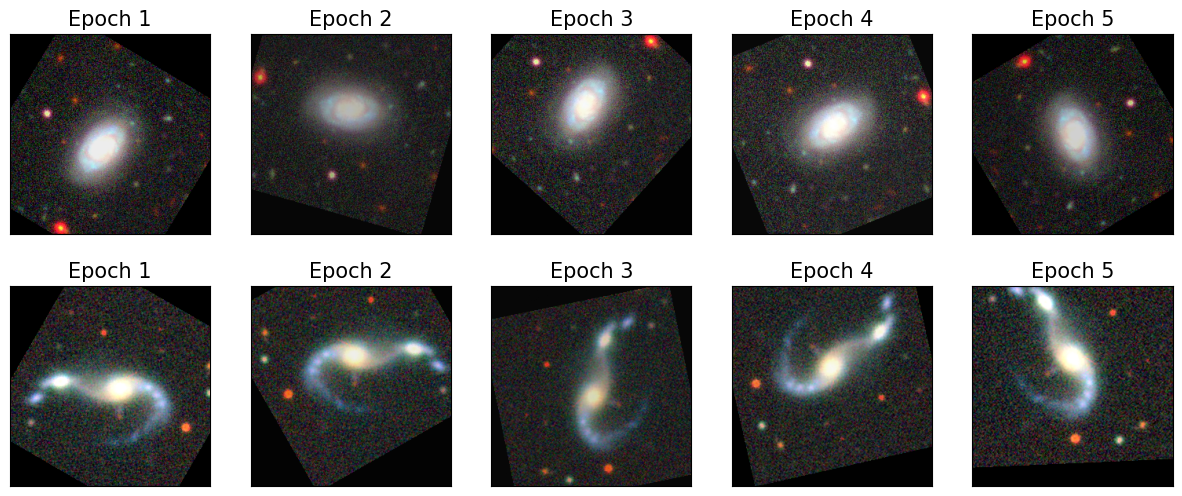

In [13]:
# Inspect two samples of augmented training data across five epochs
fig = plt.figure(figsize=(15, 6))
for epoch in range(5):
    img_batch, label_batch = next(iter(gal_train_dl))
    img = img_batch[0]
    ax = fig.add_subplot(2, 5, epoch+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Epoch {epoch+1}", size=15)
    ax.imshow(img.permute(1, 2, 0))

    img = img_batch[1]
    ax = fig.add_subplot(2, 5, epoch+6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Epoch {epoch+1}", size=15)
    ax.imshow(img.permute(1, 2, 0))

plt.show()

In [14]:
# Get sample of inputs and targets from train dataloader
for inputs, targets in gal_train_dl:
    print(inputs.shape)
    print(targets.shape)
    break

torch.Size([32, 3, 256, 256])
torch.Size([32])


# Baseline MLP Models

As a starting point, I will implement a simple **multilayer perceptron (MLP)** which flattens the input image and passes it through a single fully connected classification layer. While this model is unlikely to achieve a high accuracy score$-$since it entirely ignores spatial structure$-$it will serve as a useful lower-bound for comparison with more complex models, spatially aware models, such as a **convolutional neural network (CNN)**. 

In [15]:
# Set up GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [31]:
# Define training and validation loops
def train(model, optimizer, loss_fn, num_epochs=5, return_history=False, 
          train_dl=gal_train_dl, valid_dl=gal_valid_dl, 
          train_ds=gal_train_ds, valid_ds=gal_valid_ds,
          scheduler=None, cyclical_scheduler=False):
    log_epochs = 1
    
    train_accuracy_hist = [0] * num_epochs
    train_loss_hist = [0] * num_epochs
    valid_accuracy_hist = [0] * num_epochs
    valid_loss_hist = [0] * num_epochs
    
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            is_correct = (torch.argmax(pred, 1) == y_batch).float().mean()
            train_loss_hist[epoch] += loss.item()
            train_accuracy_hist[epoch] += is_correct

            if scheduler and cyclical_scheduler:
                scheduler.step()
    
        train_loss_hist[epoch] /= len(train_ds)/batch_size
        train_accuracy_hist[epoch] /= len(train_ds)/batch_size
    
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch) 
                
                is_correct = (torch.argmax(pred, 1) == y_batch).float().mean()
                valid_loss_hist[epoch] += loss.item()
                valid_accuracy_hist[epoch] += is_correct 
    
            valid_loss_hist[epoch] /= len(valid_ds)/batch_size
            valid_accuracy_hist[epoch] /= len(valid_ds)/batch_size
            
        if scheduler and not cyclical_scheduler: 
            scheduler.step()
            
        if epoch % log_epochs == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}]:")
            print(f"\tTrain Loss: {train_loss_hist[epoch]:0.4f}\tTrain Accuracy: {train_accuracy_hist[epoch]:0.4f}")
            print(f"\tValid Loss: {valid_loss_hist[epoch]:0.4f}\tValid Accuracy: {valid_accuracy_hist[epoch]:0.4f}")

    if return_history:
        return train_loss_hist, train_accuracy_hist, valid_loss_hist, valid_accuracy_hist

In [323]:
# Define and train simple MLP model
mlp = nn.Sequential(nn.Flatten(), nn.Linear(256*256*3, 10))
mlp = mlp.to(device)

n_params = sum(p.numel() for p in mlp.parameters())
print(f"Number of parameters: {n_params}")

loss_fn = nn.CrossEntropyLoss() # expects logits
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

train(mlp, optimizer, loss_fn)

Epoch [1/5]:
	Train Loss: 9.3703	Train Accuracy: 0.1762
	Valid Loss: 8.3097	Valid Accuracy: 0.2376
Epoch [2/5]:
	Train Loss: 4.9017	Train Accuracy: 0.2001
	Valid Loss: 5.3736	Valid Accuracy: 0.1855
Epoch [3/5]:
	Train Loss: 4.6050	Train Accuracy: 0.2035
	Valid Loss: 5.4842	Valid Accuracy: 0.1919
Epoch [4/5]:
	Train Loss: 4.7045	Train Accuracy: 0.2118
	Valid Loss: 8.3153	Valid Accuracy: 0.0908
Epoch [5/5]:
	Train Loss: 5.4490	Train Accuracy: 0.2061
	Valid Loss: 8.0156	Valid Accuracy: 0.0972


In the first epoch, the simple MLP model achieved a validation accuracy of approximately 0.24, which is ~2.4x better than random chance. However, the model's validation accuracy decreased every epoch, suggesting overfitting. In the fifth epoch, the model's validation accuracy deteriorated to ~0.1, which is no better than as guessing. 

This highlights the limitations of a model incapable of understanding spatial relationships in the data. While this suggests that CNNs are likely more appropriate for this classification task, I will first explore whether an MLP with a hidden layer and a ReLU activation function, capable of capturing non-linearities in the data, might perform better than the simple MLP. 

In [325]:
# Define an MLP with a single hidden layer and ReLU activation function
mlp_2 = nn.Sequential(
    nn.Flatten(), 
    nn.Linear(256*256*3, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 10)
)
mlp_2 = mlp_2.to(device)

n_params = sum(p.numel() for p in mlp_2.parameters())
print(f"Number of parameters: {n_params}")

loss_fn = nn.CrossEntropyLoss() # expects logits
optimizer = optim.Adam(mlp_2.parameters(), lr=0.001)

train(mlp_2, optimizer, loss_fn)

Epoch [1/5]:
	Train Loss: 3.8871	Train Accuracy: 0.1335
	Valid Loss: 2.3023	Valid Accuracy: 0.1455
Epoch [2/5]:
	Train Loss: 2.2658	Train Accuracy: 0.1507
	Valid Loss: 2.2822	Valid Accuracy: 0.1455
Epoch [3/5]:
	Train Loss: 2.2492	Train Accuracy: 0.1509
	Valid Loss: 2.2697	Valid Accuracy: 0.1455
Epoch [4/5]:
	Train Loss: 2.2451	Train Accuracy: 0.1505
	Valid Loss: 2.2620	Valid Accuracy: 0.1455
Epoch [5/5]:
	Train Loss: 2.2317	Train Accuracy: 0.1507
	Valid Loss: 2.2574	Valid Accuracy: 0.1455


It does not appear that the slightly more sophisticated MLP performs a lot better than the simple MLP. As a next step I will explore CNN architectures capable of extracting relavant spatial features from image data.

# Baseline CNN models

I will start with a **basic CNN architecture** consisting of two convolutional layers with ReLU activation and max pooling, followed by a fully connected classification layer. Again, this model is also unlikely to perform a lot better than random chance, but it will serve as a benchmark for more complex models I hope to explore later. 

In [357]:
# Define a simple CNN model with two convolutional and pooling layers
cnn = torch.nn.Sequential()

cnn.add_module("conv1", torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding="same"))
cnn.add_module("relu1", torch.nn.ReLU())
cnn.add_module("pooling1", torch.nn.MaxPool2d(2))

cnn.add_module("conv2", torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same"))
cnn.add_module("relu2", torch.nn.ReLU())
cnn.add_module("pooling2", torch.nn.MaxPool2d(2))

cnn.add_module("flatten", torch.nn.Flatten())

linear_input_size = cnn(inputs).shape[1]
cnn.add_module("linear1", torch.nn.Linear(linear_input_size, 10))

n_params = sum(p.numel() for p in cnn.parameters())
print(f"Number of parameters: {n_params}")

cnn = cnn.to(device)

# Define optimizer and loss functions
loss_fn = nn.CrossEntropyLoss() # expects logits, not probabilities
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

train(cnn, optimizer, loss_fn)

Number of parameters: 2640842
Epoch [1/5]:
	Train Loss: 2.0636	Train Accuracy: 0.2507
	Valid Loss: 1.9754	Valid Accuracy: 0.2455
Epoch [2/5]:
	Train Loss: 1.8559	Train Accuracy: 0.3152
	Valid Loss: 1.7847	Valid Accuracy: 0.3432
Epoch [3/5]:
	Train Loss: 1.7551	Train Accuracy: 0.3580
	Valid Loss: 1.7209	Valid Accuracy: 0.3675
Epoch [4/5]:
	Train Loss: 1.7029	Train Accuracy: 0.3816
	Valid Loss: 1.6673	Valid Accuracy: 0.3970
Epoch [5/5]:
	Train Loss: 1.6650	Train Accuracy: 0.3975
	Valid Loss: 1.6485	Valid Accuracy: 0.3992


# Deeper CNN Models

The two layer CNN performs a lot better than random chance on the training and validation sets; its validation accuracy increased per epoch from 0.23 in the first to 0.4 in the fifth. 

On the strength of this promising result, I will turn to **deeper CNN architectures** with three and four convolutional layers, to observe how adding depth to the model may improve the model's ability to extract spatial features and make accurate class predictions. 

In [332]:
# Increase depth to three convolutional and pooling layers
cnn_3 = torch.nn.Sequential()

cnn_3.add_module("conv1", nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding="same"))
cnn_3.add_module("relu1", nn.ReLU())
cnn_3.add_module("pooling1", nn.MaxPool2d(2))

cnn_3.add_module("conv2", nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same"))
cnn_3.add_module("relu2", tnn.ReLU())
cnn_3.add_module("pooling2", nn.MaxPool2d(2))

cnn_3.add_module("conv3", nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding="same"))
cnn_3.add_module("relu3", nn.ReLU())
cnn_3.add_module("pooling3", nn.MaxPool2d(2))

cnn_3.add_module("flatten", nn.Flatten())

linear_input_size = cnn_3(inputs).shape[1]
cnn_3.add_module("linear1", nn.Linear(linear_input_size, 10))

n_params = sum(p.numel() for p in cnn_3.parameters())
print(f"Number of parameters: {n_params}")

cnn_3 = cnn_3.to(device)

# Define optimizer and loss functions
loss_fn = nn.CrossEntropyLoss() # expects logits, not probabilities
optimizer = optim.Adam(cnn_3.parameters(), lr=0.001)

train(cnn_3, optimizer, loss_fn)

Number of parameters: 1403978
Epoch [1/5]:
	Train Loss: 2.0086	Train Accuracy: 0.2429
	Valid Loss: 1.9399	Valid Accuracy: 0.2684
Epoch [2/5]:
	Train Loss: 1.8423	Train Accuracy: 0.3225
	Valid Loss: 1.8763	Valid Accuracy: 0.3481
Epoch [3/5]:
	Train Loss: 1.6932	Train Accuracy: 0.3870
	Valid Loss: 1.6618	Valid Accuracy: 0.4071
Epoch [4/5]:
	Train Loss: 1.5823	Train Accuracy: 0.4262
	Valid Loss: 1.5813	Valid Accuracy: 0.4357
Epoch [5/5]:
	Train Loss: 1.5226	Train Accuracy: 0.4498
	Valid Loss: 1.5059	Valid Accuracy: 0.4598


The three layer CNN's final validation accuracy is nearly 0.46, dramatically better than random chance for a ten class classification problem. It appears that increasing model depth may improve model performance. 

Next, I will create a four layer CNN, and train it over 50 epochs, to identify when and at what level its performance begins to plateau. 

In [371]:
# Increase depth to four convolutional and pooling layers
cnn_4 = nn.Sequential()

cnn_4.add_module("conv1", nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding="same"))
cnn_4.add_module("relu1", nn.ReLU())
cnn_4.add_module("pooling1", nn.MaxPool2d(2))

cnn_4.add_module("conv2", nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same"))
cnn_4.add_module("relu2", nn.ReLU())
cnn_4.add_module("pooling2", nn.MaxPool2d(2))

cnn_4.add_module("conv3", nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding="same"))
cnn_4.add_module("relu3", nn.ReLU())
cnn_4.add_module("pooling3", nn.MaxPool2d(2))

cnn_4.add_module("conv4", nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding="same"))
cnn_4.add_module("relu4", nn.ReLU())
cnn_4.add_module("pooling4", nn.MaxPool2d(2))

cnn_4.add_module("flatten", nn.Flatten())

linear_input_size = cnn_4(inputs).shape[1]
cnn_4.add_module("linear1", nn.Linear(linear_input_size, 10))

n_params = sum(p.numel() for p in cnn_4.parameters())
print(f"Number of parameters: {n_params}")

cnn_4 = cnn_4.to(device)

# Define optimizer and loss functions
loss_fn = nn.CrossEntropyLoss() # expects logits, not probabilities
optimizer = optim.Adam(cnn_4.parameters(), lr=0.001)

train_loss_hist, train_accuracy_hist, valid_loss_hist, valid_accuracy_hist = train(
    model=cnn_4, optimizer=optimizer, loss_fn=loss_fn, num_epochs=50, return_history=True)

Number of parameters: 1043786
Epoch [1/50]:
	Train Loss: 1.9904	Train Accuracy: 0.2560
	Valid Loss: 1.7914	Valid Accuracy: 0.3365
Epoch [2/50]:
	Train Loss: 1.6619	Train Accuracy: 0.3946
	Valid Loss: 1.4927	Valid Accuracy: 0.4436
Epoch [3/50]:
	Train Loss: 1.4911	Train Accuracy: 0.4572
	Valid Loss: 1.3845	Valid Accuracy: 0.4812
Epoch [4/50]:
	Train Loss: 1.3563	Train Accuracy: 0.5095
	Valid Loss: 1.2657	Valid Accuracy: 0.5453
Epoch [5/50]:
	Train Loss: 1.2694	Train Accuracy: 0.5495
	Valid Loss: 1.2124	Valid Accuracy: 0.5712
Epoch [6/50]:
	Train Loss: 1.1947	Train Accuracy: 0.5744
	Valid Loss: 1.1589	Valid Accuracy: 0.5784
Epoch [7/50]:
	Train Loss: 1.1330	Train Accuracy: 0.6024
	Valid Loss: 1.0650	Valid Accuracy: 0.6329
Epoch [8/50]:
	Train Loss: 1.0805	Train Accuracy: 0.6249
	Valid Loss: 1.0018	Valid Accuracy: 0.6635
Epoch [9/50]:
	Train Loss: 1.0461	Train Accuracy: 0.6396
	Valid Loss: 1.0044	Valid Accuracy: 0.6594
Epoch [10/50]:
	Train Loss: 1.0142	Train Accuracy: 0.6534
	Valid Loss:

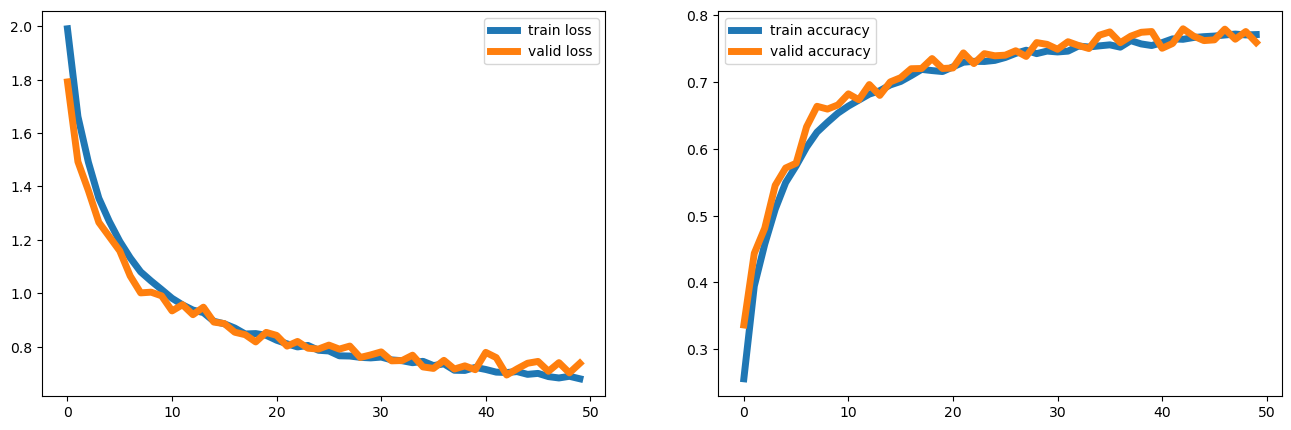

In [384]:
# Plot model performance
fig = plt.figure(figsize=(16, 5))

fig.add_subplot(1, 2, 1)
plt.plot(train_loss_hist, lw=5, label="train loss")
plt.plot(valid_loss_hist, lw=5, label="valid loss")
plt.legend()

train_accuracy_hist_ = [i.item() for i in train_accuracy_hist]
valid_accuracy_hist_ = [i.item() for i in valid_accuracy_hist]

fig.add_subplot(1, 2, 2)
plt.plot(train_accuracy_hist_, lw=5, label="train accuracy")
plt.plot(valid_accuracy_hist_, lw=5, label="valid accuracy")
plt.legend()

plt.show()

The four-layer CNN model shows strong and consistent improvements over 50 training epochs, with validation accuracy rising steadily from 0.34 in the first epoch to a peak of approximately 0.78 by the 43rd–47th epoch. After this point, both training and validation accuracy begin to plateau around 0.76–0.77, indicating that the model is approaching its learning capacity under the current configuration. The training and validation accuracy and losses remain closely aligned across all epochs, suggesting that the model is not overfitting.

I will now turn to a qualitative inspection of its predictions—examining which samples are correctly classified and which are misclassified. This analysis will help identify whether the model’s errors are systematic or if they correspond to inherently ambiguous or visually similar classes.

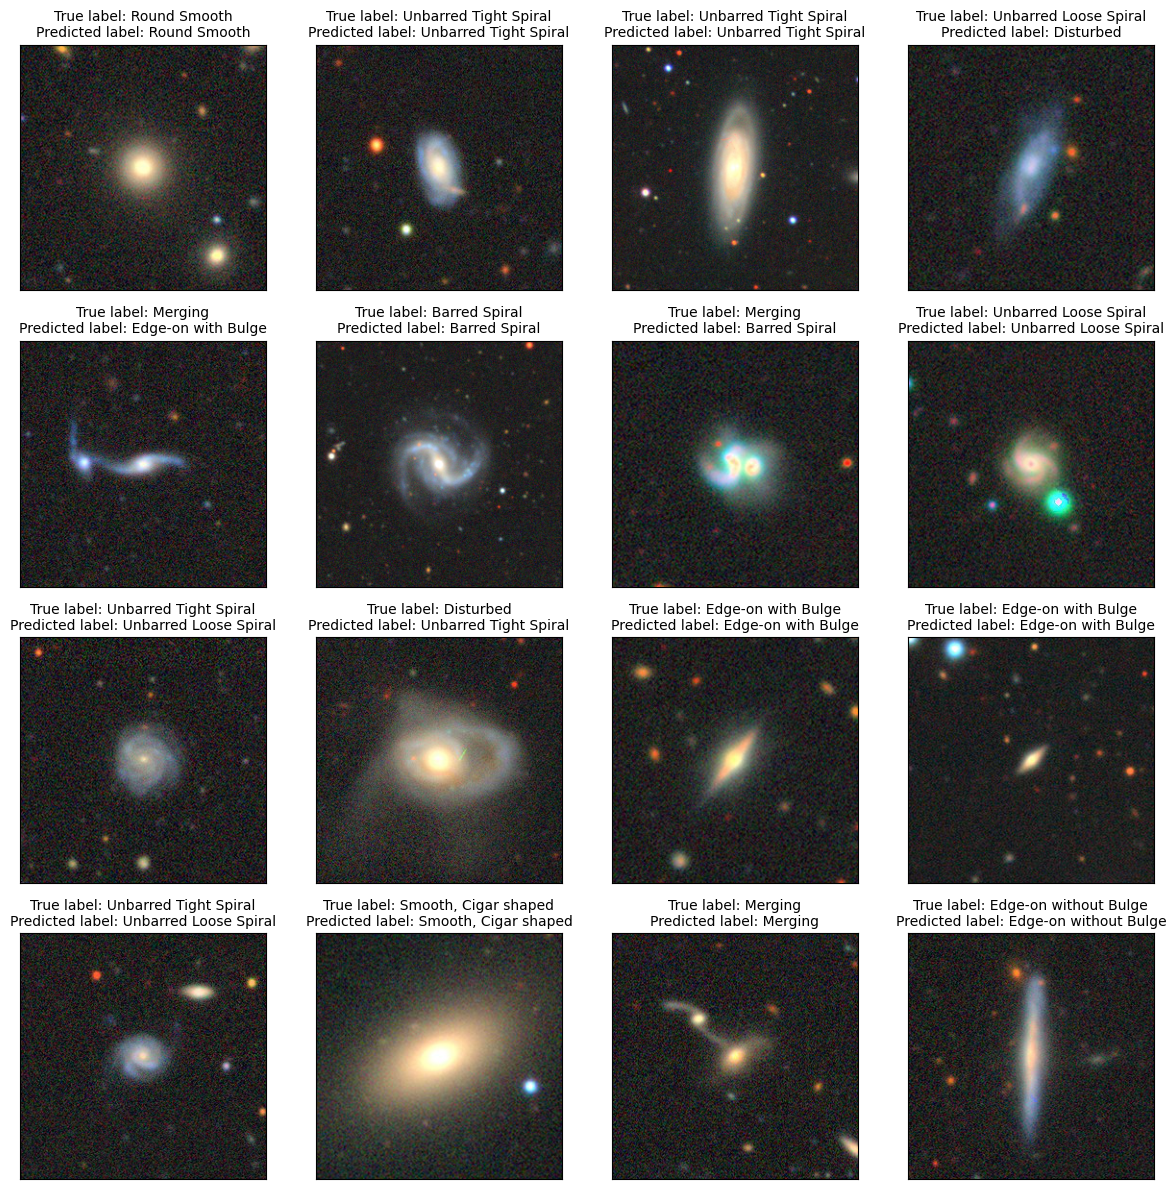

In [385]:
# Plot validation samples, true labels and model predictions
plt.figure(figsize=(12, 12))

for i in range(16):
    xi = gal_valid_ds[i][0].unsqueeze(0)
    true_label = gal_valid_ds[i][1]

    image = xi.squeeze(0).permute(1, 2, 0).numpy()

    xi = xi.to(device)
    
    with torch.no_grad():
        pred = torch.argmax(cnn_4(xi), 1).item()

    true_label = galaxy10cls_lookup(true_label)
    pred_label = galaxy10cls_lookup(pred)

    plt.subplot(4, 4, i+1)
    plt.imshow(image, cmap="binary")
    plt.title(f"True label: {true_label}\nPredicted label: {pred_label}", fontsize=10)
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

The model's misclassifications appear qualitatively reasonable. The model occasionally mistakes merging galaxies for cigar shaped galaxies, and edge-on and disturbed galaxies for unbarred spiral galaxies. The errors reflect the intrinsic difficulty of galaxy classification, rather than something pathalogical about the model. In other words, the model seems to be learning real patterns in the input dataset.

I would like to see whether increasing the depth of a basic CNN model from four to five layers will further improve validation accuracy. I'll start by running a five layer model for a small number of epochs, and compare its performance to the four layer model.

In [358]:
# Increase depth to five convolutional and pooling layers
cnn_5 = nn.Sequential()

cnn_5.add_module("conv1", nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding="same"))
cnn_5.add_module("relu1", nn.ReLU())
cnn_5.add_module("pooling1", nn.MaxPool2d(2))

cnn_5.add_module("conv2", nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same"))
cnn_5.add_module("relu2", nn.ReLU())
cnn_5.add_module("pooling2", nn.MaxPool2d(2))

cnn_5.add_module("conv3", nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding="same"))
cnn_5.add_module("relu3", nn.ReLU())
cnn_5.add_module("pooling3", nn.MaxPool2d(2))

cnn_5.add_module("conv4", nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding="same"))
cnn_5.add_module("relu4", nn.ReLU())
cnn_5.add_module("pooling4", nn.MaxPool2d(2))

cnn_5.add_module("conv5", nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding="same"))
cnn_5.add_module("relu5", nn.ReLU())
cnn_5.add_module("pooling5", nn.MaxPool2d(2))

cnn_5.add_module("flatten", nn.Flatten())

linear_input_size = cnn_5(inputs).shape[1]
cnn_5.add_module("linear1", nn.Linear(linear_input_size, 10))

n_params = sum(p.numel() for p in cnn_5.parameters())
print(f"Number of parameters: {n_params}")

cnn_5 = cnn_5.to(device)

# Define optimizer and loss functions
loss_fn = nn.CrossEntropyLoss() # expects logits, not probabilities
optimizer = optim.Adam(cnn_5.parameters(), lr=0.001)

train(cnn_5, optimizer, loss_fn, 10)

Number of parameters: 1896266
Epoch [1/10]:
	Train Loss: 2.0438	Train Accuracy: 0.2266
	Valid Loss: 1.8515	Valid Accuracy: 0.3100
Epoch [2/10]:
	Train Loss: 1.7792	Train Accuracy: 0.3247
	Valid Loss: 1.7211	Valid Accuracy: 0.3538
Epoch [3/10]:
	Train Loss: 1.6403	Train Accuracy: 0.3896
	Valid Loss: 1.5523	Valid Accuracy: 0.4263
Epoch [4/10]:
	Train Loss: 1.5215	Train Accuracy: 0.4303
	Valid Loss: 1.4838	Valid Accuracy: 0.4570
Epoch [5/10]:
	Train Loss: 1.4424	Train Accuracy: 0.4653
	Valid Loss: 1.4178	Valid Accuracy: 0.4763
Epoch [6/10]:
	Train Loss: 1.3658	Train Accuracy: 0.5006
	Valid Loss: 1.3521	Valid Accuracy: 0.5021
Epoch [7/10]:
	Train Loss: 1.2837	Train Accuracy: 0.5352
	Valid Loss: 1.2527	Valid Accuracy: 0.5445
Epoch [8/10]:
	Train Loss: 1.2124	Train Accuracy: 0.5666
	Valid Loss: 1.2287	Valid Accuracy: 0.5600
Epoch [9/10]:
	Train Loss: 1.1365	Train Accuracy: 0.6023
	Valid Loss: 1.1119	Valid Accuracy: 0.6064
Epoch [10/10]:
	Train Loss: 1.0609	Train Accuracy: 0.6293
	Valid Loss:

While increasing the model depth from three to four layers improved performance, increasing the depth from four to five did not result in a significant performance improvement: At the end of the tenth epoch, the validation accuracy of the four layer model was approximately 0.67, while that of the five layer model was approximately 0.64. One explanation for this is that the five layer model has markedly more parameters than the four layer model -- 1.89M vs 1.04M, and this additional complexity likely made optimization more difficult, resulting in the model fitting to noise rather than meaningful patterns in the data. 

# Transfer Learning

I will apply **transfer learning using ResNet18**, a large pretrained model, by freezing its feature extraction layers weights, and replacing and retraining its fully connected layers. This will allow me to **leverage the ResNet18's feature extraction ability** to achieve a higher classification accuracy on my image dataset. I will also use a **weighted loss function** to account for the class imbalance. 

Later, I will try an alternate approach: I will **fine-tune ResNet18** by initializing the pretrained model, and retraining deeper and deeper layers, in addition to the fully connected layer. 

In [122]:
## ResNet18 expects the input data to be normalized
# I will re-create the dataset and dataloader objects accordingly
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=(-180, 180), translate=(0.05, 0.15), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_valid = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Generate training and validation dataset objects
gal_train_ds = Galaxy10Dataset(images=images, labels=labels, transform=transform_train)
gal_valid_ds = Galaxy10Dataset(images=images, labels=labels, train=False, transform=transform_valid)

# Generate training and validation dataloader objects
batch_size = 32
gal_train_dl = DataLoader(gal_train_ds, batch_size=batch_size)
gal_valid_dl = DataLoader(gal_valid_ds, batch_size=batch_size)

In [19]:
# Apply transfer learning using ResNet18 as a feature extractor
weights = ResNet50_Weights.DEFAULT
resnet50_feature_extractor = resnet50(weights=weights)
linear_input_size = resnet50_feature_extractor.fc.in_features
resnet50_feature_extractor.fc = nn.Linear(linear_input_size, 10)

resnet50_feature_extractor = resnet50_feature_extractor.to(device)

_, class_counts = np.unique(gal_train_ds.labels, return_counts=True)

# Compute class weights for weighted loss function
unique_train_labels = np.unique(gal_train_ds.labels)
train_labels = gal_train_ds.labels
class_weights = compute_class_weight(class_weight="balanced", classes=unique_train_labels, y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

loss_fn = nn.CrossEntropyLoss(weight=class_weights) # expects logits, not probabilities
optimizer = optim.Adam(resnet50_feature_extractor.fc.parameters(), lr=0.001) # only provide fc layer to optimizer

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_loss_hist, train_accuracy_hist, valid_loss_hist, valid_accuracy_hist = train(
    resnet50_feature_extractor, optimizer, loss_fn, 2, True, gal_train_dl, gal_valid_dl, gal_train_ds, gal_valid_ds, exp_lr_scheduler)

Epoch [1/2]:
	Train Loss: 1.7350	Train Accuracy: 0.4051
	Valid Loss: 1.6135	Valid Accuracy: 0.4509
Epoch [2/2]:
	Train Loss: 1.4951	Train Accuracy: 0.4778
	Valid Loss: 1.5094	Valid Accuracy: 0.4744


Simply using ResNet50 as a feature extractor with a trainable fully connected layer is performing as well as I expected. I will now try to progressively unfreeze everything except the first few layers and retrain the model to see if additional fine tuning may improve performance. 

ResNet50 has several groups of layers. I will start by unfreezing layers 2, 3 and 4 in addition to the fully connected layer. 

In [30]:
# Fine tune deeper layers of ResNet50
weights = ResNet50_Weights.DEFAULT
resnet50_fine_tuned = resnet50(weights=weights)
linear_input_size = resnet50_fine_tuned.fc.in_features
resnet50_fine_tuned.fc = nn.Linear(linear_input_size, 10)

resnet50_fine_tuned = resnet50_fine_tuned.to(device)

for param in resnet50_fine_tuned.parameters():
    param.requires_grad = False
for param in resnet50_fine_tuned.layer2.parameters():
    param.requires_grad = True
for param in resnet50_fine_tuned.layer3.parameters():
    param.requires_grad = True
for param in resnet50_fine_tuned.layer4.parameters():
    param.requires_grad = True
for param in resnet50_fine_tuned.fc.parameters():
    param.requires_grad = True

# Compute class weights for weighted loss function
unique_train_labels = np.unique(gal_train_ds.labels)
train_labels = gal_train_ds.labels
class_weights = compute_class_weight(class_weight="balanced", classes=unique_train_labels, y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

loss_fn = nn.CrossEntropyLoss(weight=class_weights) # expects logits, not probabilities
optimizer = optim.Adam([param for param in resnet50_fine_tuned.parameters() if param.requires_grad==True], lr=0.001) # only provide fc layer to optimizer
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) # decay LR by a factor of 0.1 every n epochs

train_loss_hist, train_accuracy_hist, valid_loss_hist, valid_accuracy_hist = train(
    resnet50_fine_tuned, optimizer, loss_fn, 25, True, gal_train_dl, gal_valid_dl, gal_train_ds, gal_valid_ds, exp_lr_scheduler)

Epoch [1/25]:
	Train Loss: 1.1839	Train Accuracy: 0.5946
	Valid Loss: 1.0125	Valid Accuracy: 0.6765
Epoch [2/25]:
	Train Loss: 0.8247	Train Accuracy: 0.7237
	Valid Loss: 0.6860	Valid Accuracy: 0.7748
Epoch [3/25]:
	Train Loss: 0.7243	Train Accuracy: 0.7554
	Valid Loss: 0.6128	Valid Accuracy: 0.7955
Epoch [4/25]:
	Train Loss: 0.6691	Train Accuracy: 0.7753
	Valid Loss: 0.6310	Valid Accuracy: 0.7991
Epoch [5/25]:
	Train Loss: 0.6257	Train Accuracy: 0.7862
	Valid Loss: 0.5891	Valid Accuracy: 0.8043
Epoch [6/25]:
	Train Loss: 0.5884	Train Accuracy: 0.8019
	Valid Loss: 0.6074	Valid Accuracy: 0.8021
Epoch [7/25]:
	Train Loss: 0.5690	Train Accuracy: 0.8084
	Valid Loss: 0.5628	Valid Accuracy: 0.8186
Epoch [8/25]:
	Train Loss: 0.5657	Train Accuracy: 0.8107
	Valid Loss: 0.5681	Valid Accuracy: 0.8130
Epoch [9/25]:
	Train Loss: 0.5326	Train Accuracy: 0.8165
	Valid Loss: 0.5431	Valid Accuracy: 0.8216
Epoch [10/25]:
	Train Loss: 0.5251	Train Accuracy: 0.8235
	Valid Loss: 0.5025	Valid Accuracy: 0.8321

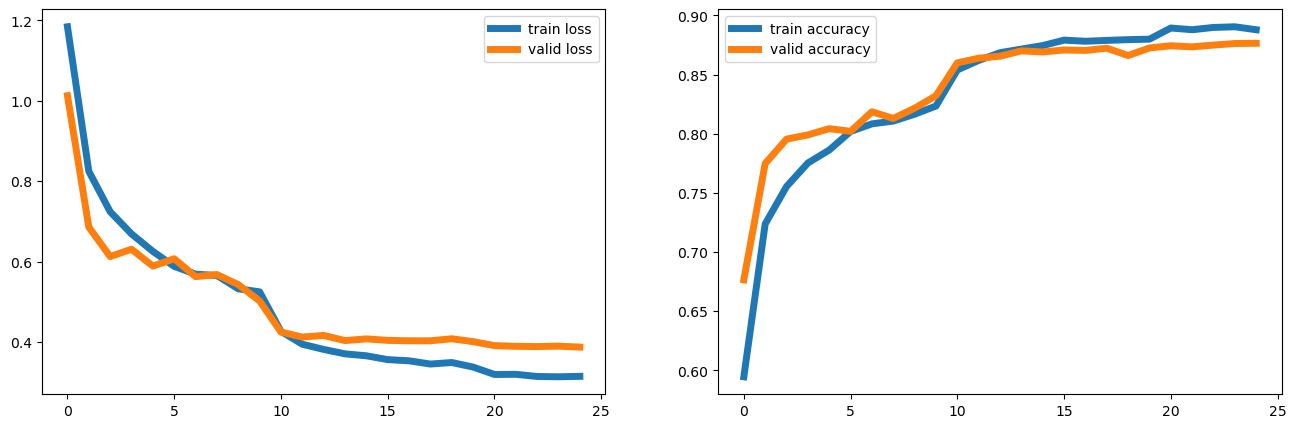

In [31]:
# Plot model performance
fig = plt.figure(figsize=(16, 5))

fig.add_subplot(1, 2, 1)
plt.plot(train_loss_hist, lw=5, label="train loss")
plt.plot(valid_loss_hist, lw=5, label="valid loss")
plt.legend()

train_accuracy_hist_ = [i.item() for i in train_accuracy_hist]
valid_accuracy_hist_ = [i.item() for i in valid_accuracy_hist]

fig.add_subplot(1, 2, 2)
plt.plot(train_accuracy_hist_, lw=5, label="train accuracy")
plt.plot(valid_accuracy_hist_, lw=5, label="valid accuracy")
plt.legend()

plt.show()

Training deeper layers of the model appreciably improved validation accuracy. The fine-tuned model achieved a maximum training and validation accuracy of 0.89 and 0.87 respectively. Judging by the trajectory of performance trendlines, it would appear that increasing the number of epochs could have resulted in marginal improvements in accuracy. 

I will now move on and **fully fine tune ResNet50**, i.e., retrain all its layers, including the convolutional layers.

In [24]:
# Fully fine tune ResNet50
weights = ResNet50_Weights.DEFAULT
resnet50_fine_tuned = resnet50(weights=weights)
linear_input_size = resnet50_fine_tuned.fc.in_features
resnet50_fine_tuned.fc = nn.Linear(linear_input_size, 10)

resnet50_fine_tuned = resnet50_fine_tuned.to(device)

# Compute class weights for weighted loss function
unique_train_labels = np.unique(gal_train_ds.labels)
train_labels = gal_train_ds.labels
class_weights = compute_class_weight(class_weight="balanced", classes=unique_train_labels, y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

loss_fn = nn.CrossEntropyLoss(weight=class_weights) # expects logits, not probabilities
optimizer = optim.SGD(resnet50_fine_tuned.parameters(), lr=0.001, momentum=0.9)

epochs = 25
exp_lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.005, steps_per_epoch=len(gal_train_dl), epochs=epochs)

train_loss_hist, train_accuracy_hist, valid_loss_hist, valid_accuracy_hist = train(
    resnet50_fine_tuned, optimizer, loss_fn, epochs, True, gal_train_dl, gal_valid_dl, gal_train_ds, gal_valid_ds, exp_lr_scheduler, True)

Epoch [1/25]:
	Train Loss: 1.6382	Train Accuracy: 0.4400
	Valid Loss: 0.8654	Valid Accuracy: 0.7051
Epoch [2/25]:
	Train Loss: 0.8169	Train Accuracy: 0.7208
	Valid Loss: 0.7356	Valid Accuracy: 0.7620
Epoch [3/25]:
	Train Loss: 0.6917	Train Accuracy: 0.7613
	Valid Loss: 0.6011	Valid Accuracy: 0.8038
Epoch [4/25]:
	Train Loss: 0.6200	Train Accuracy: 0.7861
	Valid Loss: 0.5806	Valid Accuracy: 0.8075
Epoch [5/25]:
	Train Loss: 0.5741	Train Accuracy: 0.8061
	Valid Loss: 0.5744	Valid Accuracy: 0.8122
Epoch [6/25]:
	Train Loss: 0.5383	Train Accuracy: 0.8144
	Valid Loss: 0.5127	Valid Accuracy: 0.8321
Epoch [7/25]:
	Train Loss: 0.5090	Train Accuracy: 0.8228
	Valid Loss: 0.5363	Valid Accuracy: 0.8269
Epoch [8/25]:
	Train Loss: 0.4769	Train Accuracy: 0.8358
	Valid Loss: 0.5206	Valid Accuracy: 0.8333
Epoch [9/25]:
	Train Loss: 0.4539	Train Accuracy: 0.8429
	Valid Loss: 0.5052	Valid Accuracy: 0.8276
Epoch [10/25]:
	Train Loss: 0.4240	Train Accuracy: 0.8520
	Valid Loss: 0.4485	Valid Accuracy: 0.8524

ValueError: Tried to step 9701 times. The specified number of total steps is 9700

In [ ]:
# Plot model performance
fig = plt.figure(figsize=(16, 5))

fig.add_subplot(1, 2, 1)
plt.plot(train_loss_hist, lw=5, label="train loss")
plt.plot(valid_loss_hist, lw=5, label="valid loss")
plt.legend()

train_accuracy_hist_ = [i.item() for i in train_accuracy_hist]
valid_accuracy_hist_ = [i.item() for i in valid_accuracy_hist]

fig.add_subplot(1, 2, 2)
plt.plot(train_accuracy_hist_, lw=5, label="train accuracy")
plt.plot(valid_accuracy_hist_, lw=5, label="valid accuracy")
plt.legend()

plt.show()

# Metrics

With a best validation accuracy of 0.88, I am now coming up against the ceiling of model performance on the Galaxy10 dataset. At this stage, I would like to go beyond overall accuracy to better understand how the model is doing. I will compute the **macro-averaged f1 score** to assess performance in the presence of class imbalance, and generate a **confusion matrix** to identify common misclassification patterns.

In [80]:
# Generate predicted labels for validation set
pred_labels = []
pred_probas = []
for x_batch, y_batch in tqdm.tqdm(gal_valid_dl):
    resnet50_fine_tuned.eval()
    with torch.no_grad():
        pred = resnet50_fine_tuned(x_batch.to(device))
        pred_labels += [i.item() for i in torch.argmax(pred, 1)]
        for i in pred.cpu().numpy():
            pred_probas.append(i)
pred_probas = np.array(pred_probas)

# Extract true labels from validation data
labels = gal_valid_ds.labels

100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [03:12<00:00,  1.15s/it]


In [62]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 10*3/4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.3f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.3f}; misclass={:0.3f}'.format(accuracy, misclass))
    plt.show()

In [102]:
# Micro-Average Precision and f1 Scores
avg_precision = average_precision_score(labels, pred_probas, average="macro")
avg_f1 = f1_score(labels, pred_labels, average="macro")
print(f"Macro average precision score: {avg_precision:0.3f}; Macro average f1 score: {avg_f1:0.3f}")

Macro average precision score: 0.846; Macro average f1 score: 0.841


The macro-averaged f1 score computes the average of f1 scores, weighing all classes, majority or minority, equally. A score of 0.841 suggests that broadly speaking the model is doing well at differentiating instances of each of the ten different classes, but there is still room to improve.

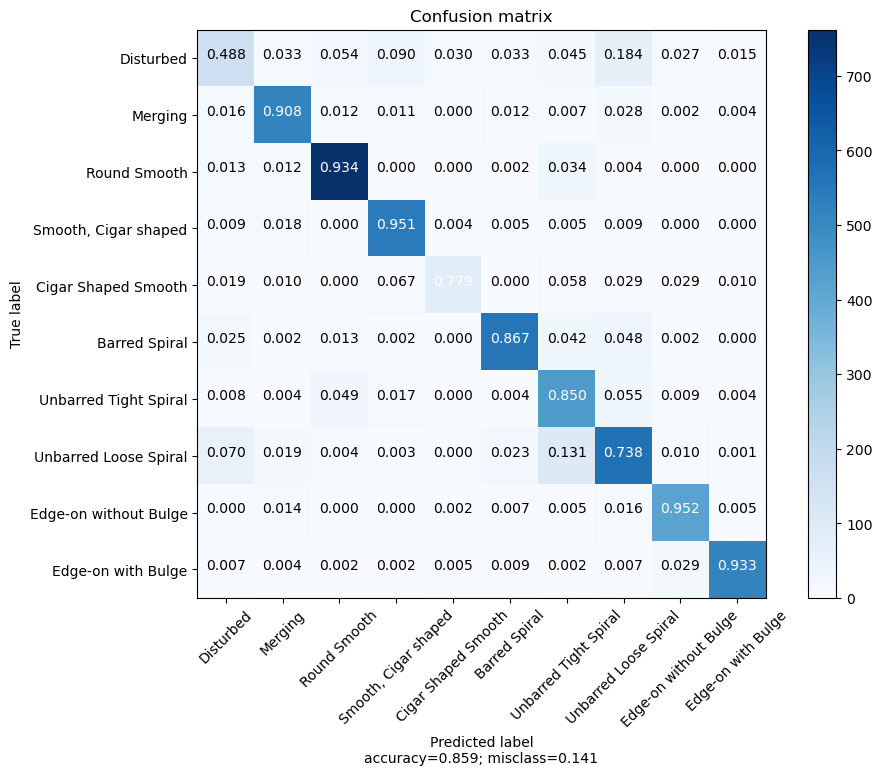

In [61]:
# Generate confusion matrix
cm = confusion_matrix(labels, pred_labels)
plot_confusion_matrix(cm, [galaxy10cls_lookup(i) for i in range(10)], normalize=True)

In [123]:
uniques

{'Disturbed': np.int64(332),
 'Merging': np.int64(568),
 'Round Smooth': np.int64(816),
 'Smooth, Cigar shaped': np.int64(568),
 'Cigar Shaped Smooth': np.int64(104),
 'Barred Spiral': np.int64(640),
 'Unbarred Tight Spiral': np.int64(527),
 'Unbarred Loose Spiral': np.int64(771),
 'Edge-on without Bulge': np.int64(440),
 'Edge-on with Bulge': np.int64(554)}

It is not surprising that the model is struggling to correctly identify members of the *Disturbed* class. It seems to be 